In [ ]:
from typing import Literal

import numpy as np
from PIL import Image, ImageOps, ImageDraw, ImageFilter

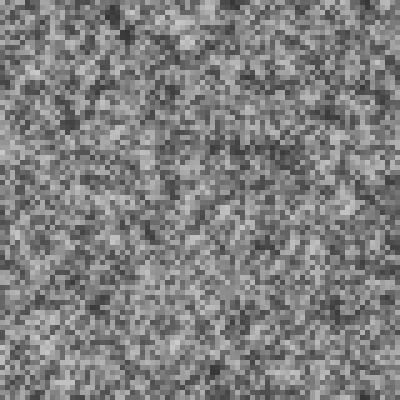

In [ ]:

def snap(val: float, mult: float) -> float:
    return mult * round(val / mult)

def display_image(img: Image.Image, scale: float = 10) -> None:
    display(ImageOps.scale(img, scale, Image.Resampling.NEAREST))

def create_symmetrical_outline(
        size: tuple[int, int],
        lines: list[tuple[tuple[float]]],
        **kwargs,
    ) -> Image.Image:
    
    image = Image.new("L", size, 0)
    draw  = ImageDraw.Draw(image)
    
    for line in lines:
        draw.line(line, fill=255)
    
    image.paste(ImageOps.flip(image), mask=ImageOps.invert(image))
    image.paste(ImageOps.mirror(image), mask=ImageOps.invert(image))
    
    return image

def create_mask_from_outline(
        base: Image.Image,
        **kwargs,
    ) -> Image.Image:
    
    mask = base.copy()
    width, height = mask.size
    
    ImageDraw.floodfill(mask, (width / 2, height / 2), 255)
    
    return mask



class Tile:
    """A framework to deal with Tiles"""
    
    def __init__(self, ref: str | Image.Image | np.typing.NDArray):
        """The base Tile class for tiling operations
        
        Returns:
            Tile: A PIL.Image wrapped around tiling methods
        """
        
        self.image: Image.Image
        
        if isinstance(ref, Image.Image):
            self.image = ref
        
        elif isinstance(ref, str):
            self.image = Image.open(ref)
        
        elif isinstance(ref, np.ndarray):
            self.image = Image.fromarray(ref)
        
        elif isinstance(ref, "Tile"):
            raise Exception("It's already a Tile dumbass")
        
        else:
            self.image = Image.new('RGB', (1, 1), (255, 0, 255))
    
    
    # PROPERTIES # -------------------------------------------------------------
    @property
    def mode(self) -> str:
        return self.image.mode
    
    @property
    def size(self) -> tuple[int, int]:
        return self.image.size
    
    @property
    def center(self) -> tuple[float, float]:
        size = self.size
        return size[0]/2, size[1]/2
    
    @property
    def as_mask(self) -> "Tile":
        """Returns the Tile as a mask (only L channel).
        Useful to ensure a mask is indeed a mask.
        
        Returns:
            Tile: The converted Tile.
        """
        
        return Tile(self.image.convert('L'))
    
    @property
    def as_array(self) -> np.typing.NDArray:
        """Returns the Tile as a numpy array.
        Useful for matrix operations.
        
        Returns:
            np.ndarray: The numpy array.
        """
        
        return np.array(self.image)
    
    
    # STATIC METHODS # ---------------------------------------------------------
    @staticmethod
    def merge_tiles(base: "Tile", head: "Tile", mask: "Tile" = None, alpha: float = 0.5) -> "Tile":
        """Merges two tiles into a new one.
        Must have a MASK or alpha value (default, 0.5).
        
        If using a MASK, it must have the same dimensions as both DATA Tiles.
        The pixel values from the MASK range from 0 (full base) to 255 (full head).
        
        The alpha value is used if no MASK is present.
        Its value is applied to the Tiles as a whole, not by pixel.
        
        Args:
            base (Tile): The Tile that goes on the bottom.
            head (Tile): The Tile that goes on top.
            mask (Tile, optional): A special Tile that controls how each pixel is merged. Defaults to None.
            alpha (float, optional): A value that controls how all pixels are merged. Defaults to 0.5.
        
        Returns:
            Tile: A new Tile resulting from the combination of both Tiles.
        """
        
        if mask is None:
            image = Image.blend(base.image, head.image, alpha)
        
        else:
            image = Image.composite(base.image, head.image, mask.as_mask.image)
        
        return Tile(image)
    
    @staticmethod
    def merge_masks(*masks: "Tile") -> "Tile":
        """Adds several MASKs together.
        Their values are combined with bitwise OR.
        
        Returns:
            Tile: A single Tile MASK
        """
        
        assert len(masks) >= 2, "Insufficient masks to be merged (<2)"
        
        base = masks[0].as_mask.as_array
        
        for mask in masks[1:]:
            base |= mask.as_mask.as_array
        
        return Tile(base)
    
    
    # METHODS # ----------------------------------------------------------------
    def copy(self) -> "Tile":
        return Tile(self.image.copy())
    
    def display(self, factor: float = 1.0, how: Image.Resampling = Image.Resampling.NEAREST) -> None:
        display(ImageOps.scale(self.image, factor, how))
    
    def rotate(self, degrees: int, expand: bool = True) -> "Tile":
        self.image = self.image.rotate(degrees, expand=True)
        
        return self
    
    def mirror(self, how: Literal['|', '-', '/', '\\']) -> "Tile":
        """Mirrors the Tile in the horizontal, vertical or diagonal directions.  
        
        Args:
            how ('-', '|', '/', '\\'): Which axis to mirror the image.
        
        Returns:
            Tile: The mirrored Tile.
        """
        
        match how:
            case '-':
                self.image = ImageOps.flip(self.image)
            
            case '|':
                self.image = ImageOps.mirror(self.image)
            
            case '\\':
                self.image = self.image.transpose(Image.Transpose.TRANSPOSE)
            
            case '/':
                self.image = self.image.transpose(Image.Transpose.TRANSVERSE)
        
        return self
    
    def scale(self, factor: float, how = None) -> "Tile":
        how = how if how is not None else Image.Resampling.NEAREST
        self.image = ImageOps.scale(self.image, factor, how)
        
        return self
    
    def smoothen(self, filters: list[ImageFilter.Filter], pad: int = 4) -> "Tile":
        """seq = (0.5, 0.5, 1.0, ...)."""
        
        w, h = self.size
        
        # Pads the image with itself
        image = self.take((w-pad, h-pad), (w+pad*2, h+pad*2)).image
        
        for f in filters:
            image = image.filter(f)
        
        # Crops the extra border, restoring the original size
        self.image = ImageOps.crop(image, pad)
        
        return self
    
    def get_cutout(self, mask: "Tile") -> "Tile":
        image = self.image.copy()
        image.putalpha(mask.as_mask.image)
        
        return Tile(image)
    
    def get_padout(self, fullsize: tuple[int, int], pos: tuple[int, int] = (0, 0)) -> "Tile":
        image = Image.new(self.image.mode, fullsize, 0)
        image.paste(self.image, pos)
        
        return Tile(image)
    
    def get_sample(self, box: tuple[int, int, int, int]) -> "Tile":
        
        return Tile(self.image.crop(box))
    
    def take(self, pos: tuple[int, int], size: tuple[int, int]) -> "Tile":
        x0, y0 = pos
        width, height = size
        wrap_width, wrap_height = self.size
        
        xidx = (np.arange(x0, x0+width) % wrap_width)
        yidx = (np.arange(y0, y0+height) % wrap_height)
        
        crop = self.as_array[np.ix_(yidx, xidx)]
        
        return Tile(crop)
    
    # GENERATORS # -------------------------------------------------------------
    @staticmethod
    def gen_ortho_mask(size: int | tuple[int, int], **kwargs) -> "Tile":
        """ Generates an orthogonal mask Tile given the size. """
        
        if isinstance(size, int):
            size = (size, size)
        
        w, h = size
        lines = [
            ((0, 0), (0, h-1)), # left
            ((0, 0), (w-1, 0)), # top
        ]
        
        outline = create_symmetrical_outline(size, lines, **kwargs)
        mask_image = create_mask_from_outline(outline)
        
        return Tile(mask_image)
    
    @staticmethod
    def gen_iso_mask(size: int, **kwargs) -> "Tile":
        """Generates an isometric mask Tile given the size.
        Always width = 2*height
        """
        
        assert size % 2 == 0, "Size must be even numbered"
        
        lines = [
            ((0, size/2-1), (size-1, 0)), # diagonal
        ]
        
        outline = create_symmetrical_outline((size*2, size), lines, **kwargs)
        mask_image = create_mask_from_outline(outline)
        
        return Tile(mask_image)
    
    @staticmethod
    def gen_hex_mask(
            size: int | tuple[int, int],
            top: Literal["flat", "point"] = "flat",
            **kwargs
        ) -> "Tile":
        
        if isinstance(size, int):
            assert size % 2 == 0, "Size must be even numbered"
        
        SQRT3BY2 = 0.866
        size = size, int(snap(size*SQRT3BY2, 4)) # nearest multiple of 4
        
        # It's easier to always create as a flat top and rotate later
        width, height = size
        
        # prop = height/width
        # print(f"{prop=:.2f} ({100*prop/SQRT3BY2:.0f}%)")
        
        # Markers (Q.uarter, M.iddle)
        QW, MW = width/4, width/2
        QH, MH = height/4, height/2
        
        # Small correction for widths 8 and 12 (outliers)
        if width in (8, 12):
            QW += 0.5
        
        lines = [
            ((0.5, MH-0.5), (QW-0.5, 0.5)), # top-left diagonal
            ((QW+0.5, 0.5), (MW, 0.5)), # top line
        ]
        
        outline = create_symmetrical_outline((width, height), lines, **kwargs)
        mask_image = create_mask_from_outline(outline)
        
        if top == 'point':
            mask_image = mask_image.rotate(90, expand=True)
        
        return Tile(mask_image)
    
    @staticmethod
    def gen_rnd_rgb(
            size: tuple[int, int],
            ranges: list[tuple[int, int]],
        ) -> "Tile":
        """ Generates a random RGB Tile from the channels ranges. """
        
        image = (Image.fromarray(
            np.stack((
                np.random.randint(ranges[0][0], ranges[0][1], size, dtype=np.uint8),
                np.random.randint(ranges[1][0], ranges[1][1], size, dtype=np.uint8),
                np.random.randint(ranges[2][0], ranges[2][1], size, dtype=np.uint8),
            ), axis=-1),
            'RGB')
        )
        
        return Tile(image)
    
    @staticmethod
    def gen_rnd_mask(
            size: tuple[int, int],
            vrange: tuple[int, int],
        ) -> "Tile":
        """ Generates a random Mask Tile"""
        
        image = Image.fromarray(np.stack(
            np.random.randint(vrange[0], vrange[1], size, dtype=np.uint8), axis=-1), 'L')
        
        return Tile(image)


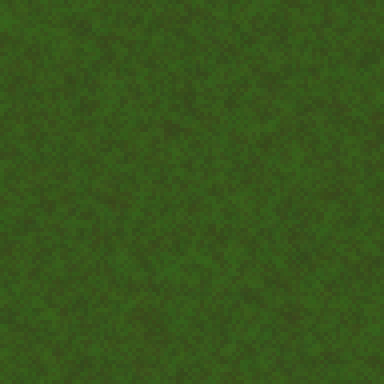

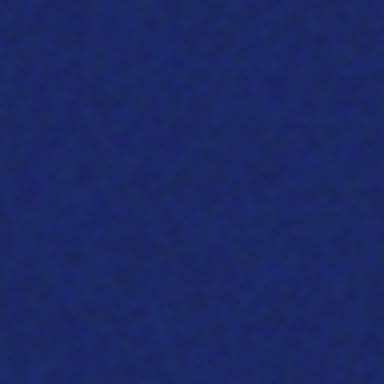

In [183]:
Tile.gen_rnd_rgb((96, 96), ((48, 64), (64, 108), (24, 32))).smoothen([ImageFilter.SMOOTH_MORE]).display(4)
Tile.gen_rnd_rgb((96, 96), ((24, 32), (32, 48), (80, 120))).smoothen([ImageFilter.SMOOTH, ImageFilter.SMOOTH]).display(4)

In [ ]:
def generate_smooth_RGB(
        size: tuple[int, int],
        ranges: list[tuple[int, int]],
        smooth_passes: int = 0,
    ) -> Image.Image:
    
    PAD = 4
    SIZE = size[0] + PAD*2, size[1] + PAD*2
    
    image = (Image.fromarray(
        np.stack((
            np.random.randint(ranges[0][0], ranges[0][1], SIZE, dtype=np.uint8),
            np.random.randint(ranges[1][0], ranges[1][1], SIZE, dtype=np.uint8),
            np.random.randint(ranges[2][0], ranges[2][1], SIZE, dtype=np.uint8),
        ), axis=-1),
        'RGB')
    )
    
    for _ in range(smooth_passes):
        image = image.filter(ImageFilter.SMOOTH_MORE)
    
    image = image.crop((PAD, PAD, SIZE[0]-PAD, SIZE[1]-PAD))
    
    return image

display(ImageOps.scale(generate_smooth_RGB((96, 96), ((48, 64), (64, 108), (24, 32)), 1), 4, Image.Resampling.NEAREST))
display(ImageOps.scale(generate_smooth_RGB((96, 96), ((24, 32), (32, 48), (80, 120)), 2), 4, Image.Resampling.NEAREST))